# Вступление

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти № 1 во всем мире, унося, по оценкам, 17,9 миллиона жизней каждый год, что составляет 31% всех смертей в мире.

Сердечная недостаточность - это распространенное событие, вызванное ССЗ, и этот набор данных содержит 12 признаков, которые могут быть использованы для прогнозирования смертности от сердечной недостаточности:

* age - Возраст пациента, (40, ..., 95) лет
* sex - Пол пациента, мужчина/женщина
* anaemia - Снижение количества эритроцитов или гемоглобина (уровень гематокрита был ниже 36%), да/нет
* diabetes - Наличие у пациента сахарного диабета, да/нет
* smoking - Курящий пациент, да/нет
* creatinine_phosphokinase - Уровень фермента креатинфосфокиназа (КФК) в крови, (23, ..., 7861) мкг/л
* high_blood_pressure - Наличие у пациента гипертонии, да/нет
* ejection_fraction - Процент крови, покидающей сердце при каждом сокращении, (14, ..., 80) %
* platelets - Уровень тромбоцитов в крови, (25.01, ..., 850.00) кровяных пластинок на 1 мкл крови
* serum_creatinine - Уровень креатинина в сыворотке,	(0.50, ..., 9.40) мг/дЛ
* serum_sodium - Уровень натрия в крови, Level of sodium in the blood, (114, ..., 148) ммоль/л
* time - Период наблюдения, (4, ..., 285) дней
* DEATH_EVENT = Смерть пациента в течение периода наблюдения, да/нет

Большинство сердечно-сосудистых заболеваний можно предотвратить, обратившись к поведенческим факторам риска, таким как употребление табака, нездоровое питание и ожирение, гиподинамия и вредное употребление алкоголя, используя общепопуляционную стратегию.

Люди с сердечно-сосудистыми заболеваниями или подверженные высокому риску (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия) нуждаются в раннем выявлении и лечении, где модель машинного обучения может оказать большую помощь.

# Подготовка

In [1]:
# Устанавливаем все необходимые библиотеки

!pip install -q --upgrade pip
!pip install -q pycaret
!pip install -q sweetviz
!pip install -q pandas-profiling[notebook]
!pip install -q lofo-importance
!pip install -q tqdm==4.54.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 10.1.0 requires pyyaml~=3.12, but you have pyyaml 5.3.1 which is incompatible.
jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.0.0 which is incompatible.


In [2]:
# Подгружаем все необходимые библиотеки

import os

import numpy as np
import pandas as pd

from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, predict_model, calibrate_model, save_model, interpret_model, get_config, evaluate_model, finalize_model, blend_models, ensemble_model

import sweetviz as sv

from pandas_profiling import ProfileReport

%matplotlib inline

pd.set_option('max_columns', None)

/opt/conda/lib/python3.7/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Устанавливаем RANDOM_SEED

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# EDA

In [4]:
# Подгружаем датасет

df = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

Произведем небольшие манипуляции над названиями и порядком фичей для большего удобства.

In [5]:
# Сделаем перестановку фичей для более логичного представления

df = df[['sex', 'age', 
         'smoking', 'diabetes', 'high_blood_pressure',
         'anaemia', 'platelets', 'ejection_fraction',
         'creatinine_phosphokinase', 'serum_creatinine','serum_sodium',
         'time', 'DEATH_EVENT']]

In [6]:
# Переименуем названия фичей

df = df.rename(columns={'smoking':'smk',
                        'diabetes':'dia',
                        'anaemia':'anm',
                        'platelets':'plt',
                        'high_blood_pressure':'hbp',
                        'creatinine_phosphokinase':'cpk',
                        'ejection_fraction':'ejf',
                        'serum_creatinine':'scr',
                        'serum_sodium':'sna',
                        'DEATH_EVENT':'death'})

In [7]:
# Обработаем бинарные фичи

df['sex'] = df['sex'].apply(lambda x: 'Female' if x==0 else 'Male')
df['smk'] = df['smk'].apply(lambda x: 'No' if x==0 else 'Yes')
df['dia'] = df['dia'].apply(lambda x: 'No' if x==0 else 'Yes')
df['anm'] = df['anm'].apply(lambda x: 'No' if x==0 else 'Yes')
df['hbp'] = df['hbp'].apply(lambda x: 'No' if x==0 else 'Yes')
df['death'] = df['death'].apply(lambda x: 'No' if x==0 else 'Yes')

Для EDA анализа датасета я использовал библиотеки [SweetViz](https://github.com/fbdesignpro/sweetviz) и [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling). Они генерят отчет в формате HTML.

In [8]:
# Формируем отчеты по датасету

my_report = sv.analyze(df)
my_report.show_html()


profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_file("PANDAS_PROFILING_REPORT.html")


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


* Датасет состоит из 299 записей (пациентов).
* Пропущенных значений нет.
* Целевая переменная не сбалансирована (68% vs 32%).
* Количественные переменные:
    * Age: Мы видим, что средний возраст пациентов составляет 60 лет, причем большинство пациентов (<75%) моложе 70 лет и старше 40 лет. Время наблюдения после их сердечной недостаточности также варьируется от 4 дней до 285 дней, в среднем 130 дней.
    * Platelets: Тромбоциты - тип клеток крови, которые отвечают за восстановление поврежденных кровеносных сосудов. У нормального человека количество тромбоцитов составляет 150 000 - 400 000 пластинок/мл крови. В нашем наборе данных 75% пациентов имеют количество тромбоцитов в пределах этого диапазона.
    * Ejection fraction: Фракция выброса это показатель (в %) того, сколько крови откачивается из желудочка при каждом сокращении. У здорового взрослого человека эта фракция составляет 55%, а сердечная недостаточность со сниженной фракцией выброса подразумевает значение < 40%. В нашем наборе данных 75% пациентов имеют это значение < 45%, что ожидаемо, потому что все они являются пациентами с сердечной недостаточностью в первую очередь.
    * Creatinine Phosphokinase: Это фермент, который присутствует в крови и помогает в восстановлении поврежденных тканей. Высокий уровень КФК подразумевает сердечную недостаточность или травму. Нормальные уровни у мужчин составляют 55-170 мкг/л, а у женщин - 30-135 мкг/л. В нашем наборе данных, поскольку все пациенты имели сердечную недостаточность, среднее значение (550 мкг/л) и медиана (250 мкг/л) выше нормы.
    * Serum Creatinine: это продукт отходов, который вырабатывается как часть мышечного метаболизма, особенно во время распада мышц. Этот креатинин фильтруется почками, и его повышенный уровень свидетельствует о плохом сердечном выбросе и возможной почечной недостаточности. Нормальные уровни находятся в диапазоне от 0,84 до 1,21 мг/дл, а в нашем наборе данных среднее и медиана превышают 1,10 мг / дл, что довольно близко к верхней границе нормального диапазона.
    * Serum sodium: это относится к уровню натрия в крови, а высокий уровень > 135 мэкв/л называется гипернатриемией, которая считается типичной для пациентов с сердечной недостаточностью. В нашем наборе данных мы находим, что среднее значение и медиана составляют > 135 мэкв/л.
* Категориальные переменные:
    * Основываясь на статистических данных, мы получаем приблизительное представление о том, что особенности образа жизни почти одинаково распределены между теми, кто умер, и теми, кто выжил. Наибольшая разница в случае высокого кровяного давления, которое, возможно, могло бы оказать большее влияние на выживаемость сердечных больных.
* Корреляции:
    * Количественные переменные:
        * Большинство пациентов, умерших после сердечной недостаточности, имеют более низкую фракцию выброса, чем те, кто выжил. Они также, по-видимому, имеют несколько более высокие уровни сывороточного креатинина и креатинфосфокиназы. Их возраст, как правило, больше 80 лет.
        * Между признаками нет сильных корреляций, за ислючением одного случая. Переменная time (период наблюдения) будет исключена из дальнейшего анализа, т.к. она имеет очень сильную корреляцию с целевой переменной.
    * Категориальыне переменные:
        * Большое количество пациентов не курили, не страдали анемией, от высокого кровяного давления или диабета.
        * Было очень мало пациентов, которые имели все четыре особенности.
        * Многие из выживших были либо курильщиками, либо диабетиками.
        * Большинство умерших не имели никаких особенностей.
        * Многие из умерших также страдали анемией и диабетом.

In [9]:
df.drop(['time'], axis=1, inplace=True)

# Feature Selection Part 1. LOFO

Отбор признаков будем проводить в два этапа.

На первом этапе используем библиотеку [LOFO (Leave One Feature Out)](https://github.com/aerdem4/lofo-importance). Она вычисляет важность набора признаков на основе выбранной метрики для модели выбора, итеративно удаляя каждый признак из набора и оценивая производительность модели с помощью схемы проверки выбора, основанной на выбранной метрике.

Если модель не передается в качестве аргумента LofoImportance, она будет запускать LightGBM в качестве модели по умолчанию.

Пока будем использовать метрику ROC AUC.

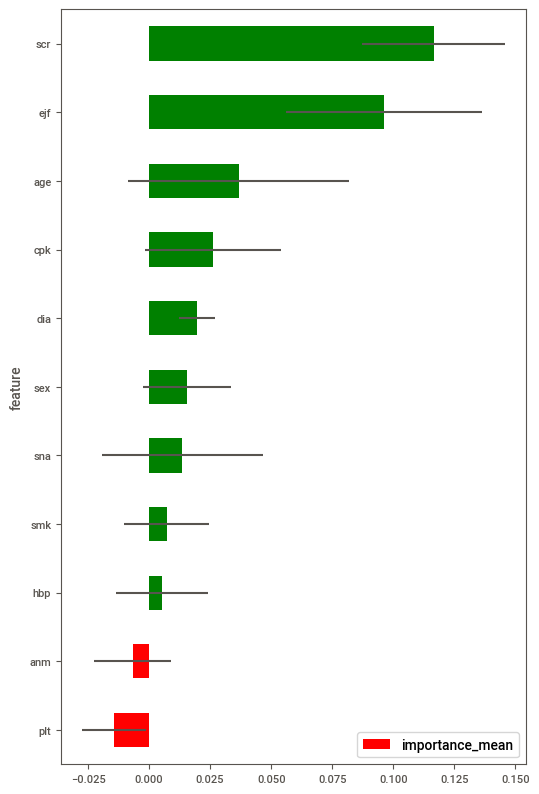

In [10]:
# Зададим нашу целевую переменную и признаки
dataset = Dataset(df=df, target='death', features=[col for col in df.columns if col != 'death'])

# Зададил схему валидации
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Зададим метрику, по которой будем определять качество модели
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# Получим среднее и значение и стандартное отклонение показателя важности
importance_df = lofo_imp.get_importance()

# Построим на графике показатели важности
plot_importance(importance_df, figsize=(6,10))

Мы видим, что самый значительный вклад в изменение метрики вносят признаки: Serum Creatinine, Ejection Fraction, Age. Зафиксируем это и перейдем ко второй части.

# Feature Selection Part 2

In [11]:
# Разделим датасет на X (фичи) и y (целевую переменную)

y = df['death'].values
X = df.drop(['death'], axis=1)

Попробуем провести отбор фичей с помощью GenericUnivariateSelect из sklearn, ориентируясь на следующую схему.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Сначала разберемся с количественными переменными. Посчитаем параметр ANOVA F-value для всех количественных переменных.

In [12]:
selection_num = GenericUnivariateSelect(f_classif, mode='k_best', param=3)
X_num = selection_num.fit_transform(X[['age', 'plt', 'ejf', 'cpk', 'scr', 'sna']], y)
display(selection_num.scores_)
display(X_num.shape)

array([20.43594646,  0.71888045, 23.09406305,  1.17325872, 28.15849226,
       11.76533129])

(299, 3)

В итоге видим, что самые высокие значения ANOVA F-value имеют следующие признаки: Age, Ejection Fraction, Serum Creatinine.

Теперь перейдем к категориальным признакам. Посчитаем параметр mutual_info_classif для категориальных переменных.

In [13]:
# Закодируем категориальные признаки с помощью OrdinalEncoder

def prepare_inputs(X):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc

X_cat = prepare_inputs(X[['sex', 'smk', 'dia', 'hbp', 'anm']])

In [14]:
selection_cat = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=3)
X_cat = selection_cat.fit_transform(X_cat, y)
display(selection_cat.scores_)
display(X_cat.shape)

array([0.        , 0.        , 0.00225588, 0.04573215, 0.04485149])

(299, 3)

Очевидно, что самые высокие значения ANOVA F-value имеют следующие признаки: Heart Blood Pressure, Anemia.

Суммировав первую и вторую часть отбора признаков делаем вывод, что в датасете требуется оставить следующие признаки + целевую переменную:
Age, Ejection Fraction, Serum Creatinine, Heart Blood Pressure, Anemia, Death.

In [15]:
df = df[['age', 'ejf', 'scr', 'hbp', 'anm', 'death']]
df.sample(5)

,age,ejf,scr,hbp,anm,death
241,65.000,30,1.3,No,No,No
277,70.000,38,1.1,No,No,No
33,50.000,30,1.2,No,Yes,No
53,70.000,50,1.0,Yes,Yes,Yes
185,60.667,30,1.5,No,Yes,Yes


# PyCaret

Для построения и модели мы будем использовать библиотеку PyCaret. Это библиотека машинного обучения с открытым исходным кодом на Python для обучения и развертывания моделей с учителем и без учителя в low-code среде.

По сравнению с другими открытыми библиотеками машинного обучения, PyCaret – это low-code альтернатива, которая поможет заменить сотни строк кода всего парой слов. Это позволяет значительно сократить время создания и оптимизации модели.

PyCaret проста и удобна в использовании. Все операции, выполняемые PyCaret, последовательно сохраняются в пайплайне полностью готовом для развертывания. Будь то добавление пропущенных значений, преобразование категориальных данных, инженерия признаков или оптимизация гиперпараметров, PyCaret сможет все это автоматизировать.

In [16]:
# Откопируем датасет
df_copy = df.copy()

In [17]:
# Создаем конфгурацию для движка сравнения моделей МО
grid = setup(data=df_copy, target=df_copy.columns[-1], train_size=0.90, # на валидационную выборку выделяем 10%,
             html=True, silent=True, verbose=False, session_id=42,
             preprocess=True,
             fix_imbalance=True, #применяем опцию fix_imbalance, которая применяет технику Synthetic Minority Over-sampling Technique
             
             categorical_features=['hbp', 'anm'], #определяем категориальные и числовые фичи
             numeric_features=['age', 'ejf', 'scr'],

#             normalize=True, normalize_method='robust', 
#             transformation=True, transformation_method='yeo-johnson',
#             pca=True, pca_method='linear', pca_components=5,
             
             polynomial_features=True, polynomial_degree=5, #включаем генерацию полиномиальных и тригонометрических признаков и их селекцию с определенным порогом
             trigonometry_features=True,
             polynomial_threshold=0.2,
             
             feature_interaction=True, #включаем генерацию interaction-признаков и их селекцию с определенным порогом
             feature_ratio=True,
             interaction_threshold=0.1,

             feature_selection=True, feature_selection_threshold=0.4, feature_selection_method='classic', #настраиваем итоговую селекцию признаков
             
             data_split_shuffle=True,
             data_split_stratify=True,
            )

Выбор метрики.

Проанализировав несколько статей по схожим проектам МО (например https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7), я пришел к выводу, что правильнее всего будет использовать метрику MCC (Matthews correlation coefficient) как основную. Так как она является более надежным статистическим показателем, которая выдает высокое значение только в том случае, если прогноз получил хорошие результаты во всех четырех категориях матрицы путаницы (истинные положительные, ложные отрицательные, истинные отрицательные и ложные положительные), ***пропорционально как размеру положительных элементов, так и размеру отрицательных элементов в наборе данных***. Метрику AUC будем использовать как дополнительное подтверждение.

Сравним производительность разных моделей МО на 5-ти фолдовой кросс-валидации.

In [18]:
# Запустим задачу сравнения производительности множества моделей МО
best = compare_models(sort='MCC', fold=10, n_select=1, turbo=False)
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7657,0.8174,0.6722,0.6326,0.6422,0.4703,0.4797,0.0650
xgboost,Extreme Gradient Boosting,0.7585,0.8314,0.6750,0.6251,0.6356,0.4582,0.4712,0.7320
ada,Ada Boost Classifier,0.7584,0.7947,0.6722,0.6163,0.6349,0.4560,0.4640,0.0920
rf,Random Forest Classifier,0.7510,0.7884,0.6514,0.6130,0.6194,0.4370,0.4478,0.3310
gbc,Gradient Boosting Classifier,0.7469,0.8060,0.6708,0.5896,0.6196,0.4326,0.4429,0.2070
catboost,CatBoost Classifier,0.7473,0.8102,0.6528,0.6030,0.6178,0.4315,0.4405,6.3010
et,Extra Trees Classifier,0.7436,0.7846,0.6278,0.6052,0.6051,0.4176,0.4267,0.2870
lda,Linear Discriminant Analysis,0.7058,0.7141,0.6250,0.5282,0.5708,0.3488,0.3533,0.0230
dt,Decision Tree Classifier,0.6953,0.6675,0.6028,0.5342,0.5613,0.3311,0.3353,0.0210
ridge,Ridge Classifier,0.6984,0.0000,0.5639,0.5408,0.5247,0.3213,0.3261,0.0180


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


В результате видим, что максимальное значение метрики  MCC (как впрочем и AUC) достигнуто моделью LightGBM. Ее мы и выберем для дальнейшего изучения и оптимизации.

Создаем модель на основе LightGBM и 5-ти фолдовой кросс-валидации.

In [19]:
# Создадим модель на основе лучшей по результатам сравнения
clf = create_model('lightgbm', fold=10)
print(clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.8618,0.8750,0.5833,0.7000,0.5345,0.5622
1,0.6296,0.8289,0.3750,0.3750,0.3750,0.1118,0.1118
2,0.7037,0.8092,0.7500,0.5000,0.6000,0.3793,0.3990
3,0.7778,0.7099,0.5556,0.7143,0.6250,0.4706,0.4781
4,0.6667,0.8395,0.5556,0.5000,0.5263,0.2703,0.2712
5,0.8889,0.9383,1.0000,0.7500,0.8571,0.7692,0.7906
6,0.8519,0.8272,0.6667,0.8571,0.7500,0.6471,0.6574
7,0.8889,0.9074,0.7778,0.8750,0.8235,0.7429,0.7456
8,0.7407,0.7716,0.6667,0.6000,0.6316,0.4324,0.4339
9,0.7308,0.6806,0.5000,0.5714,0.5333,0.3453,0.3468


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


Визуально оценим производительность модели. В этом нам поможем дашборд PyCaret, который создается с помощью команды evaluate_model.

In [20]:
evaluate_model(clf)

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


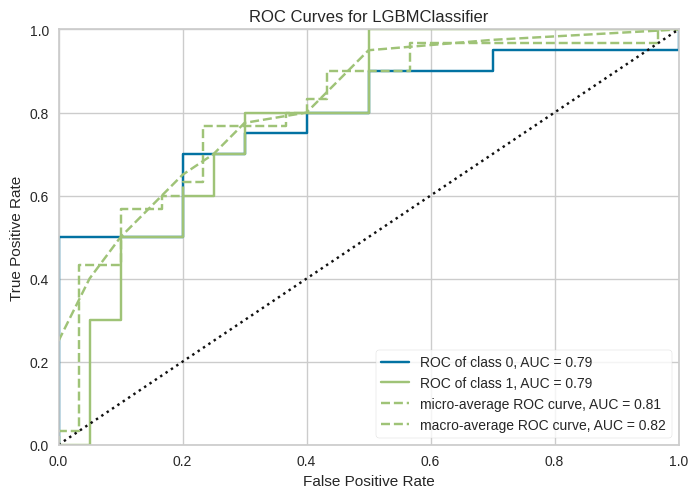

In [21]:
plot_model(clf, plot = 'auc')

Теперь проведем тюнинг модели в автоматическом режиме (метрика - MCC (среднее значение + стандартное отклонение), 5-ти фолдовая кросс-валидация)

In [22]:
tuned = tune_model(clf, optimize='mcc', n_iter=20, fold=10)
print(tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7407,0.7632,0.7500,0.5455,0.6316,0.4392,0.4524
1,0.7407,0.7401,0.8750,0.5385,0.6667,0.4735,0.5110
2,0.8148,0.9079,0.8750,0.6364,0.7368,0.5994,0.6175
3,0.7037,0.6605,0.5556,0.5556,0.5556,0.3333,0.3333
4,0.8148,0.8704,0.8889,0.6667,0.7619,0.6154,0.6325
5,0.7407,0.8642,0.7778,0.5833,0.6667,0.4615,0.4743
6,0.8148,0.8765,0.6667,0.7500,0.7059,0.5714,0.5735
7,0.8148,0.8889,0.7778,0.7000,0.7368,0.5946,0.5966
8,0.7407,0.8179,0.6667,0.6000,0.6316,0.4324,0.4339
9,0.6923,0.6458,0.5000,0.5000,0.5000,0.2778,0.2778


LGBMClassifier(bagging_fraction=0.6, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.048, max_depth=-1,
               min_child_samples=50, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=170, n_jobs=-1, num_leaves=70, objective=None,
               random_state=42, reg_alpha=4, reg_lambda=0.7, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [23]:
evaluate_model(tuned)

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.048
max_depth,-1
min_child_samples,50
min_child_weight,0.001
min_split_gain,0.9
n_estimators,170


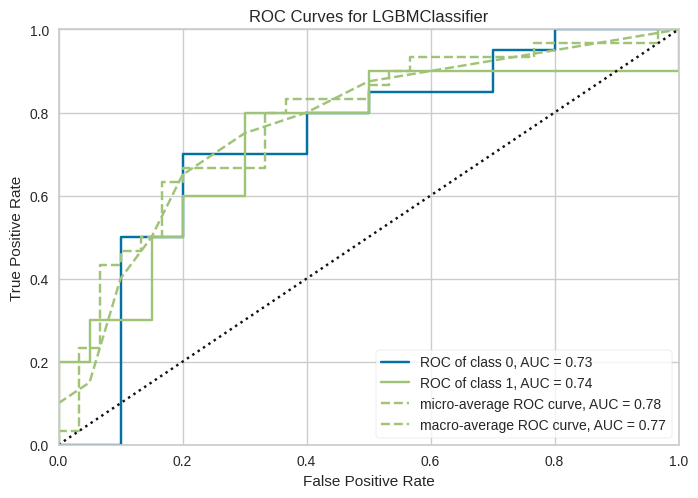

In [24]:
plot_model(tuned, plot = 'auc')

После тюнинга мы достигли небольшого улучшения по MCC и AUC c таким же небольшим увеличением стандартного отклонения от среднего значения.

Далее откалибруем модель. При выполнении классификационных экспериментов часто требуется предсказать не только метки классов, но и получить вероятность предсказания. Эта вероятность дает нам некоторую уверенность. Хорошо откалиброванные классификаторы - это вероятностные классификаторы, для которых выход вероятности может быть непосредственно интерпретирован как уровень достоверности.

In [25]:
calibrated = calibrate_model(tuned, fold=10)
print(calibrated)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7407,0.7566,0.7500,0.5455,0.6316,0.4392,0.4524
1,0.7037,0.7467,0.6250,0.5000,0.5556,0.3374,0.3421
2,0.8148,0.9079,0.8750,0.6364,0.7368,0.5994,0.6175
3,0.7037,0.6728,0.5556,0.5556,0.5556,0.3333,0.3333
4,0.7037,0.8580,0.6667,0.5455,0.6000,0.3684,0.3731
5,0.7407,0.8519,0.7778,0.5833,0.6667,0.4615,0.4743
6,0.8148,0.8951,0.6667,0.7500,0.7059,0.5714,0.5735
7,0.8148,0.8765,0.7778,0.7000,0.7368,0.5946,0.5966
8,0.7778,0.8395,0.6667,0.6667,0.6667,0.5000,0.5000
9,0.6538,0.6667,0.5000,0.4444,0.4706,0.2148,0.2156


CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.6,
                                                     bagging_freq=5,
                                                     boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     feature_fraction=0.4,
                                                     importance_type='split',
                                                     learning_rate=0.048,
                                                     max_depth=-1,
                                                     min_child_samples=50,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.9,
                                                     n_estimators=170,
                                            

In [26]:
evaluate_model(calibrated)

,Parameters
base_estimator,"LGBMClassifier(bagging_fraction=0.6, bagging_f..."
cv,"StratifiedKFold(n_splits=10, random_state=42, ..."
method,sigmoid


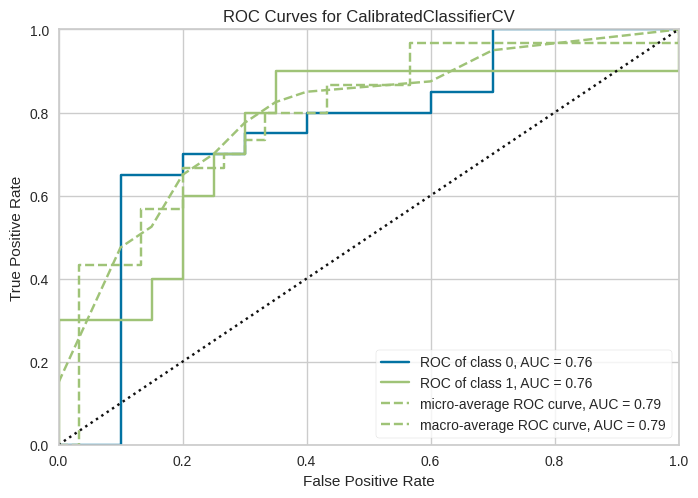

In [27]:
plot_model(calibrated, plot = 'auc')

После выполнения калибровки мы получили слегка более правильную калибровочную кривую, а также уменьшение стандартного отклонения в обеих метриках.

Предскажем значения целевой переменной на отложенной 10%-ой выборке с помощью тюнингованной и откалиброванной моделей.

In [28]:
predict_model(clf)
predict_model(tuned)
predict_model(calibrated)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7667,0.7900,0.5000,0.7143,0.5882,0.4324,0.4458


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6667,0.7350,0.6000,0.5000,0.5455,0.2857,0.2887


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7000,0.7550,0.6000,0.5455,0.5714,0.3415,0.3424


,scr_Power5,scr,age_Power5,sin(age),age,cos(ejf),cos(scr),ejf_Power5,ejf,sin(age)_multiply_scr,...,cos(ejf)_multiply_sin(age),scr_divide_sin(age),cos(scr)_divide_ejf,scr_divide_ejf_Power5,cos(scr)_divide_scr,ejf_Power5_divide_cos(scr),age_Power5_divide_ejf_Power5,death,Label,Score
0,1.610510,1.10,1.680700e+09,0.773891,70.0,-0.952413,0.453596,777600000.0,60.0,0.851280,...,-0.737064,1.421389,0.007560,1.414609e-09,0.412360,1.714300e+09,2.161394,No,No,0.7852
1,3.712929,1.30,1.160291e+09,0.826829,65.0,0.991203,0.267499,9765625.0,25.0,1.074877,...,0.819555,1.572273,0.010700,1.331200e-07,0.205768,3.650716e+07,118.813766,No,Yes,0.7619
2,0.237305,0.75,7.776000e+08,-0.304811,60.0,0.955074,0.731689,79235168.0,38.0,-0.228608,...,-0.291117,-2.460544,0.019255,9.465494e-09,0.975585,1.082908e+08,9.813824,No,No,0.8271
3,40.841000,2.10,3.276800e+09,-0.993889,80.0,-0.903692,-0.504846,52521876.0,35.0,-2.087166,...,0.898169,-2.112913,-0.014424,3.998334e-08,-0.240403,-1.040354e+08,62.389240,No,Yes,0.8031
4,1.000000,1.00,3.125000e+08,-0.262375,50.0,0.525322,0.540302,184528128.0,45.0,-0.262375,...,-0.137831,-3.811341,0.012007,5.419228e-09,0.540302,3.415276e+08,1.693509,No,No,0.7482
5,2.488321,1.20,1.306912e+08,-0.916522,42.0,-0.666938,0.362358,102400000.0,40.0,-1.099826,...,0.611263,-1.309298,0.009059,1.171875e-08,0.301965,2.825937e+08,1.276282,No,No,0.8467
6,1.000000,1.00,1.680700e+09,0.773891,70.0,-0.275163,0.540302,1419857.0,17.0,0.773891,...,-0.212946,1.292172,0.031782,7.042963e-07,0.540302,2.627894e+06,1183.710815,No,Yes,0.8043
7,1.610510,1.10,5.032844e+08,-0.999755,55.0,0.991203,0.453596,9765625.0,25.0,-1.099731,...,-0.990960,-1.100269,0.018144,1.126400e-07,0.412360,2.152934e+07,51.536320,Yes,Yes,0.6945
8,20.523693,1.83,4.704270e+09,-0.923458,86.0,0.955074,-0.256311,79235168.0,38.0,-1.689929,...,-0.881971,-1.981681,-0.006745,2.309581e-08,-0.140061,-3.091369e+08,59.370991,Yes,Yes,0.8304
9,1.000000,1.00,1.845281e+08,0.850904,45.0,-0.903692,0.540302,52521876.0,35.0,0.850904,...,-0.768955,1.175221,0.015437,1.903969e-08,0.540302,9.720832e+07,3.513357,Yes,No,0.8838


Финализируем и сохраним нашу модель для дальнешего развертывания.

In [29]:
final_clf = finalize_model(calibrated)
save_model(final_clf, model_name = 'rds_diploma')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['hbp', 'anm'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'ejf', 'scr'],
                                       target='death', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_...
                                                                       learning_rate=0.048,
                                                                       max_depth=-1,
                                                                       min_child_samples=50,
                                   

# БОНУС. Ансамблирование, блендинг, стекинг и вот всё :)

К сожалению, мне не удалось добиться улучшения метрики при использовании ансамблирования. Для того чтобы разобраться с этими возможностями Pycaet Требуется гораздо больше времени.

In [30]:
blended_clf = blend_models(compare_models(n_select = 5), method = 'soft')
predict_model(blended_clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.8026,0.8750,0.5833,0.7000,0.5345,0.5622
1,0.6296,0.7895,0.3750,0.3750,0.3750,0.1118,0.1118
2,0.7778,0.8421,0.8750,0.5833,0.7000,0.5345,0.5622
3,0.7778,0.7407,0.5556,0.7143,0.6250,0.4706,0.4781
4,0.7407,0.8148,0.6667,0.6000,0.6316,0.4324,0.4339
5,0.8148,0.9012,1.0000,0.6429,0.7826,0.6341,0.6814
6,0.8148,0.8580,0.5556,0.8333,0.6667,0.5455,0.5669
7,0.8519,0.9136,0.7778,0.7778,0.7778,0.6667,0.6667
8,0.7037,0.8025,0.5556,0.5556,0.5556,0.3333,0.3333
9,0.8077,0.7083,0.6250,0.7143,0.6667,0.5324,0.5347


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6667,0.7350,0.4000,0.5000,0.4444,0.2105,0.2132


,scr_Power5,scr,age_Power5,sin(age),age,cos(ejf),cos(scr),ejf_Power5,ejf,sin(age)_multiply_scr,...,cos(ejf)_multiply_sin(age),scr_divide_sin(age),cos(scr)_divide_ejf,scr_divide_ejf_Power5,cos(scr)_divide_scr,ejf_Power5_divide_cos(scr),age_Power5_divide_ejf_Power5,death,Label,Score
0,1.610510,1.10,1.680700e+09,0.773891,70.0,-0.952413,0.453596,777600000.0,60.0,0.851280,...,-0.737064,1.421389,0.007560,1.414609e-09,0.412360,1.714300e+09,2.161394,No,No,0.7831
1,3.712929,1.30,1.160291e+09,0.826829,65.0,0.991203,0.267499,9765625.0,25.0,1.074877,...,0.819555,1.572273,0.010700,1.331200e-07,0.205768,3.650716e+07,118.813766,No,Yes,0.5027
2,0.237305,0.75,7.776000e+08,-0.304811,60.0,0.955074,0.731689,79235168.0,38.0,-0.228608,...,-0.291117,-2.460544,0.019255,9.465494e-09,0.975585,1.082908e+08,9.813824,No,No,0.5892
3,40.841000,2.10,3.276800e+09,-0.993889,80.0,-0.903692,-0.504846,52521876.0,35.0,-2.087166,...,0.898169,-2.112913,-0.014424,3.998334e-08,-0.240403,-1.040354e+08,62.389240,No,Yes,0.7573
4,1.000000,1.00,3.125000e+08,-0.262375,50.0,0.525322,0.540302,184528128.0,45.0,-0.262375,...,-0.137831,-3.811341,0.012007,5.419228e-09,0.540302,3.415276e+08,1.693509,No,No,0.8536
5,2.488321,1.20,1.306912e+08,-0.916522,42.0,-0.666938,0.362358,102400000.0,40.0,-1.099826,...,0.611263,-1.309298,0.009059,1.171875e-08,0.301965,2.825937e+08,1.276282,No,No,0.8889
6,1.000000,1.00,1.680700e+09,0.773891,70.0,-0.275163,0.540302,1419857.0,17.0,0.773891,...,-0.212946,1.292172,0.031782,7.042963e-07,0.540302,2.627894e+06,1183.710815,No,Yes,0.8606
7,1.610510,1.10,5.032844e+08,-0.999755,55.0,0.991203,0.453596,9765625.0,25.0,-1.099731,...,-0.990960,-1.100269,0.018144,1.126400e-07,0.412360,2.152934e+07,51.536320,Yes,No,0.6281
8,20.523693,1.83,4.704270e+09,-0.923458,86.0,0.955074,-0.256311,79235168.0,38.0,-1.689929,...,-0.881971,-1.981681,-0.006745,2.309581e-08,-0.140061,-3.091369e+08,59.370991,Yes,Yes,0.9022
9,1.000000,1.00,1.845281e+08,0.850904,45.0,-0.903692,0.540302,52521876.0,35.0,0.850904,...,-0.768955,1.175221,0.015437,1.903969e-08,0.540302,9.720832e+07,3.513357,Yes,No,0.8943


In [31]:
blended_clf = blend_models(compare_models(n_select = 5), method = 'hard')
predict_model(blended_clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.0000,0.8750,0.5833,0.7000,0.5345,0.5622
1,0.6296,0.0000,0.3750,0.3750,0.3750,0.1118,0.1118
2,0.7407,0.0000,0.7500,0.5455,0.6316,0.4392,0.4524
3,0.7778,0.0000,0.5556,0.7143,0.6250,0.4706,0.4781
4,0.7037,0.0000,0.6667,0.5455,0.6000,0.3684,0.3731
5,0.8148,0.0000,1.0000,0.6429,0.7826,0.6341,0.6814
6,0.8148,0.0000,0.5556,0.8333,0.6667,0.5455,0.5669
7,0.8519,0.0000,0.7778,0.7778,0.7778,0.6667,0.6667
8,0.7407,0.0000,0.6667,0.6000,0.6316,0.4324,0.4339
9,0.7692,0.0000,0.6250,0.6250,0.6250,0.4583,0.4583


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7333,0.6750,0.5000,0.6250,0.5556,0.3684,0.3731


,scr_Power5,scr,age_Power5,sin(age),age,cos(ejf),cos(scr),ejf_Power5,ejf,sin(age)_multiply_scr,...,cos(ejf)_multiply_cos(scr),cos(ejf)_multiply_sin(age),scr_divide_sin(age),cos(scr)_divide_ejf,scr_divide_ejf_Power5,cos(scr)_divide_scr,ejf_Power5_divide_cos(scr),age_Power5_divide_ejf_Power5,death,Label
0,1.610510,1.10,1.680700e+09,0.773891,70.0,-0.952413,0.453596,777600000.0,60.0,0.851280,...,-0.432011,-0.737064,1.421389,0.007560,1.414609e-09,0.412360,1.714300e+09,2.161394,No,No
1,3.712929,1.30,1.160291e+09,0.826829,65.0,0.991203,0.267499,9765625.0,25.0,1.074877,...,0.265146,0.819555,1.572273,0.010700,1.331200e-07,0.205768,3.650716e+07,118.813766,No,No
2,0.237305,0.75,7.776000e+08,-0.304811,60.0,0.955074,0.731689,79235168.0,38.0,-0.228608,...,0.698817,-0.291117,-2.460544,0.019255,9.465494e-09,0.975585,1.082908e+08,9.813824,No,No
3,40.841000,2.10,3.276800e+09,-0.993889,80.0,-0.903692,-0.504846,52521876.0,35.0,-2.087166,...,0.456225,0.898169,-2.112913,-0.014424,3.998334e-08,-0.240403,-1.040354e+08,62.389240,No,Yes
4,1.000000,1.00,3.125000e+08,-0.262375,50.0,0.525322,0.540302,184528128.0,45.0,-0.262375,...,0.283833,-0.137831,-3.811341,0.012007,5.419228e-09,0.540302,3.415276e+08,1.693509,No,No
5,2.488321,1.20,1.306912e+08,-0.916522,42.0,-0.666938,0.362358,102400000.0,40.0,-1.099826,...,-0.241670,0.611263,-1.309298,0.009059,1.171875e-08,0.301965,2.825937e+08,1.276282,No,No
6,1.000000,1.00,1.680700e+09,0.773891,70.0,-0.275163,0.540302,1419857.0,17.0,0.773891,...,-0.148671,-0.212946,1.292172,0.031782,7.042963e-07,0.540302,2.627894e+06,1183.710815,No,Yes
7,1.610510,1.10,5.032844e+08,-0.999755,55.0,0.991203,0.453596,9765625.0,25.0,-1.099731,...,0.449606,-0.990960,-1.100269,0.018144,1.126400e-07,0.412360,2.152934e+07,51.536320,Yes,No
8,20.523693,1.83,4.704270e+09,-0.923458,86.0,0.955074,-0.256311,79235168.0,38.0,-1.689929,...,-0.244796,-0.881971,-1.981681,-0.006745,2.309581e-08,-0.140061,-3.091369e+08,59.370991,Yes,Yes
9,1.000000,1.00,1.845281e+08,0.850904,45.0,-0.903692,0.540302,52521876.0,35.0,0.850904,...,-0.488267,-0.768955,1.175221,0.015437,1.903969e-08,0.540302,9.720832e+07,3.513357,Yes,No


In [32]:
bagged_clf = ensemble_model(tuned, method = 'Bagging')
predict_model(bagged_clf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7407,0.7500,0.7500,0.5455,0.6316,0.4392,0.4524
1,0.7778,0.7500,0.8750,0.5833,0.7000,0.5345,0.5622
2,0.8148,0.8750,0.8750,0.6364,0.7368,0.5994,0.6175
3,0.7778,0.6667,0.5556,0.7143,0.6250,0.4706,0.4781
4,0.7407,0.8827,0.6667,0.6000,0.6316,0.4324,0.4339
5,0.7407,0.8457,0.7778,0.5833,0.6667,0.4615,0.4743
6,0.8148,0.8704,0.7778,0.7000,0.7368,0.5946,0.5966
7,0.8148,0.8951,0.7778,0.7000,0.7368,0.5946,0.5966
8,0.7407,0.8210,0.6667,0.6000,0.6316,0.4324,0.4339
9,0.6538,0.6389,0.5000,0.4444,0.4706,0.2148,0.2156


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7333,0.7400,0.7000,0.5833,0.6364,0.4286,0.4330


,scr_Power5,scr,age_Power5,sin(age),age,cos(ejf),cos(scr),ejf_Power5,ejf,sin(age)_multiply_scr,...,cos(ejf)_multiply_sin(age),scr_divide_sin(age),cos(scr)_divide_ejf,scr_divide_ejf_Power5,cos(scr)_divide_scr,ejf_Power5_divide_cos(scr),age_Power5_divide_ejf_Power5,death,Label,Score
0,1.610510,1.10,1.680700e+09,0.773891,70.0,-0.952413,0.453596,777600000.0,60.0,0.851280,...,-0.737064,1.421389,0.007560,1.414609e-09,0.412360,1.714300e+09,2.161394,No,No,0.7559
1,3.712929,1.30,1.160291e+09,0.826829,65.0,0.991203,0.267499,9765625.0,25.0,1.074877,...,0.819555,1.572273,0.010700,1.331200e-07,0.205768,3.650716e+07,118.813766,No,Yes,0.7701
2,0.237305,0.75,7.776000e+08,-0.304811,60.0,0.955074,0.731689,79235168.0,38.0,-0.228608,...,-0.291117,-2.460544,0.019255,9.465494e-09,0.975585,1.082908e+08,9.813824,No,No,0.8122
3,40.841000,2.10,3.276800e+09,-0.993889,80.0,-0.903692,-0.504846,52521876.0,35.0,-2.087166,...,0.898169,-2.112913,-0.014424,3.998334e-08,-0.240403,-1.040354e+08,62.389240,No,Yes,0.8338
4,1.000000,1.00,3.125000e+08,-0.262375,50.0,0.525322,0.540302,184528128.0,45.0,-0.262375,...,-0.137831,-3.811341,0.012007,5.419228e-09,0.540302,3.415276e+08,1.693509,No,No,0.6871
5,2.488321,1.20,1.306912e+08,-0.916522,42.0,-0.666938,0.362358,102400000.0,40.0,-1.099826,...,0.611263,-1.309298,0.009059,1.171875e-08,0.301965,2.825937e+08,1.276282,No,No,0.8590
6,1.000000,1.00,1.680700e+09,0.773891,70.0,-0.275163,0.540302,1419857.0,17.0,0.773891,...,-0.212946,1.292172,0.031782,7.042963e-07,0.540302,2.627894e+06,1183.710815,No,Yes,0.7942
7,1.610510,1.10,5.032844e+08,-0.999755,55.0,0.991203,0.453596,9765625.0,25.0,-1.099731,...,-0.990960,-1.100269,0.018144,1.126400e-07,0.412360,2.152934e+07,51.536320,Yes,Yes,0.6494
8,20.523693,1.83,4.704270e+09,-0.923458,86.0,0.955074,-0.256311,79235168.0,38.0,-1.689929,...,-0.881971,-1.981681,-0.006745,2.309581e-08,-0.140061,-3.091369e+08,59.370991,Yes,Yes,0.8169
9,1.000000,1.00,1.845281e+08,0.850904,45.0,-0.903692,0.540302,52521876.0,35.0,0.850904,...,-0.768955,1.175221,0.015437,1.903969e-08,0.540302,9.720832e+07,3.513357,Yes,No,0.9348
